In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
import numpy as np

In [3]:
import matplotlib
matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white") 

# display plots in this notebook
%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Naive GAN

In [44]:
tf.reset_default_graph()

In [6]:
class GAN():
    def __init__(self, x_dim, z_dim, h_dim, activation_func=tf.nn.relu, optimizer=tf.train.AdamOptimizer()):
        def generator(z, reuse=False):
            with tf.variable_scope('G', reuse=reuse) as scope:
                G_h = tf.layers.dense(z, h_dim, activation=activation_func)
                G_x = tf.layers.dense(G_h, x_dim, activation=tf.nn.sigmoid)
            return G_x
        
        def discriminator(x, reuse=False):
            with tf.variable_scope('D', reuse=reuse) as scope:
                D_h = tf.layers.dense(x, h_dim, activation=activation_func)
                D_logit = tf.layers.dense(D_h, 1)
                D_prob = tf.nn.sigmoid(D_logit)
            return D_prob, D_logit
        
        
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.x_dim, self.z_dim, self.h_dim = x_dim, z_dim, h_dim
            
            self.x = tf.placeholder(tf.float32, shape=[None, x_dim])
            self.z = tf.placeholder(tf.float32, shape=[None, z_dim])
            
            self.G_sample = generator(self.z)
            D_prob_real, D_logit_real = discriminator(self.x)
            D_prob_fake, D_logit_fake = discriminator(self.G_sample, reuse=True)
            
            D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
            D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
            self.D_loss = D_loss_real + D_loss_fake
            
            self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
            
            var = tf.trainable_variables()
            var_G = [v for v in var if v.name.startswith('G')]
            var_D = [v for v in var if v.name.startswith('D')]
            
            self.D_solver = tf.train.AdamOptimizer().minimize(self.D_loss, var_list=var_D)
            self.G_solver = tf.train.AdamOptimizer().minimize(self.G_loss, var_list=var_G)
            
            self.saver = tf.train.Saver()
            
            self.init = tf.global_variables_initializer()
        
        self.sess = tf.Session(graph=self.graph)
        self.sess.run(self.init)
        
    @staticmethod
    def sample_z(m, n):
        return np.random.uniform(-1, 1, [m, n])
        
    def train_on_batch(self, x):
        batch_size = x.shape[0]
        D_loss_curr, _ = self.sess.run([self.D_loss, self.D_solver], feed_dict={self.x: x, self.z: self.sample_z(batch_size, self.z_dim)})
        G_loss_curr, _ = self.sess.run([self.G_loss, self.G_solver], feed_dict={self.z: self.sample_z(batch_size, self.z_dim)})
        
    def evaluate(self, x):
        batch_size = x.shape[0]
        D_loss_curr = self.sess.run(self.D_loss, feed_dict={self.x: x, self.z: self.sample_z(batch_size, self.z_dim)})
        G_loss_curr = self.sess.run(self.G_loss, feed_dict={self.z: self.sample_z(batch_size, self.z_dim)})
        return D_loss_curr, G_loss_curr
        
    def generate(self):
        return self.sess.run(self.G_sample, feed_dict={self.z: self.sample_z(1, self.z_dim)})[0,:]
    
    def save(self, save_path, global_step=False):
        if global_step:
            self.saver.save(self.sess, save_path, global_step)
        else:
            self.saver.save(self.sess, save_path)
        
    def load_weights(self, save_path, latest_checkpoint=False):
        if latest_checkpoint:
            self.saver.restore(self.sess, tf.train.latest_checkpoint(save_path))
        else:
            self.saver.restore(self.sess, save_path)

In [7]:
gan = GAN(x_dim=784, z_dim=100, h_dim=200)

In [8]:
batch_size = 128
for i in range(100001):
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    gan.train_on_batch(batch_x)

    if i % 500 == 0:
        D_loss_curr, G_loss_curr = gan.evaluate(mnist.train.images)
        print 'iter %d, D loss: %f, G loss: %f' % (i, D_loss_curr, G_loss_curr)

iter 0, D loss: 0.784234, G loss: 2.548984
iter 500, D loss: 0.012329, G loss: 6.738493
iter 1000, D loss: 0.024586, G loss: 5.560492
iter 1500, D loss: 0.010000, G loss: 7.104901
iter 2000, D loss: 0.017506, G loss: 5.613017
iter 2500, D loss: 0.045556, G loss: 5.620552
iter 3000, D loss: 0.057579, G loss: 4.653121
iter 3500, D loss: 0.071214, G loss: 7.002142
iter 4000, D loss: 0.079168, G loss: 6.051127
iter 4500, D loss: 0.100606, G loss: 5.020208
iter 5000, D loss: 0.129148, G loss: 5.108934
iter 5500, D loss: 0.211493, G loss: 5.137205
iter 6000, D loss: 0.155951, G loss: 5.168524
iter 6500, D loss: 0.218785, G loss: 4.094863
iter 7000, D loss: 0.275862, G loss: 4.638323
iter 7500, D loss: 0.302693, G loss: 3.594737
iter 8000, D loss: 0.515902, G loss: 3.211112
iter 8500, D loss: 0.443832, G loss: 3.019376
iter 9000, D loss: 0.311423, G loss: 3.743948
iter 9500, D loss: 0.465436, G loss: 3.311969
iter 10000, D loss: 0.478216, G loss: 2.583326
iter 10500, D loss: 0.452192, G loss:

KeyboardInterrupt: 

[]

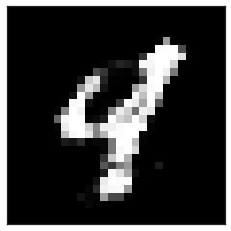

In [11]:
plt.figure()
plt.imshow(gan.generate().reshape((28,28)), cmap='gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])

In [37]:
gan.sess.close()